### General Form of a Gaussian

$p(x) = \exp(-\frac{1}{2}x^\top\Lambda x + x^\top\nu - \ln Z)$

with $\ln Z = \frac{1}{2}\nu^\top\Lambda^{-1}\nu + \frac{D}{2}\ln 2\pi + \frac{1}{2}\ln\det(\Lambda^{-1})$.

### Relation to covariance and mean

$\Sigma = \Lambda^{-1}$

$\mu = \Sigma\nu$

### Form of unnormalised Gaussians

$u(x) = \exp(-\frac{1}{2}x^\top\Lambda x + x^\top\nu + \ln \beta)$

And the intergal is

$\int u(x) d x = \beta Z$

In [1]:
from matplotlib import pyplot
import numpy
import sys
sys.path.append('../src/')
import factors
import measures
import densities
import conditionals

# Create a density object

In [2]:
R, D = 1, 2
# Create covariance
rand_nums = numpy.random.randn(D,D)
Sigma_phi_xy = 5. * numpy.ones((D,D))
Sigma_phi_xy += numpy.eye(D)
Sigma_phi_xy = numpy.tile(Sigma_phi_xy, (R, 1, 1))
# Create mean
mu_phi_xy = numpy.zeros((R, D))
# Create Density object
phi_xy = densities.GaussianDensity(Sigma=Sigma_phi_xy, mu=mu_phi_xy)

## `sample()` and `evaluate()` functions

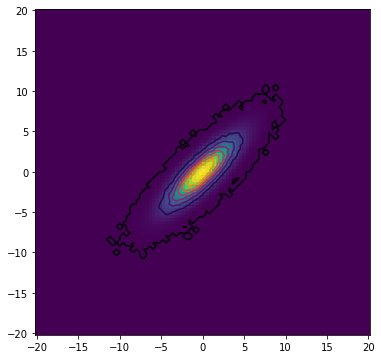

In [3]:
# Sample
x_samples = phi_xy.sample(100000)

# Plot
pyplot.figure(figsize=(6,6))
xrange = numpy.linspace(-20,20,100)
xmesh, ymesh = numpy.meshgrid(xrange, xrange)
x_grid = numpy.vstack([xmesh.flatten(), ymesh.flatten()])
density = phi_xy.evaluate(x_grid.T)[0].reshape((100,100))
hist, xedges, yedges =  numpy.histogram2d(x_samples[:,0,1], x_samples[:,0,0], range=[[-20,20], [-20,20]], bins=100)
#numpy_hist, xedges, yedges =  numpy.histogram2d(numpy_samples[:,1], numpy_samples[:,0], range=[[-20,20], [-20,20]], bins=100)
ax1 = pyplot.subplot(111)
pyplot.pcolor(xrange, xrange, density, shading='auto')
#pyplot.pcolor(xedges[:-1], yedges[:-1], numpy_hist, shading='auto')
pyplot.contour(xedges[:-1], yedges[:-1], hist, cmap='inferno')
pyplot.show()

# Integration

## Simple `integrate()` function

$\int (Ax+a) (Bx+b)^\top d\phi(x)$

In [4]:
# Generate matrices & vectors
k, l = 6, 3
A_mat, a_vec = numpy.random.randn(k,D), numpy.random.randn(k)
B_mat, b_vec = numpy.random.randn(l,D), numpy.random.randn(l)
# Integrate with respect to Gaussian density
AB_phi_xy = phi_xy.integrate('Ax_aBx_b_outer', A_mat=A_mat, a_vec=a_vec, B_mat=B_mat, b_vec=b_vec)

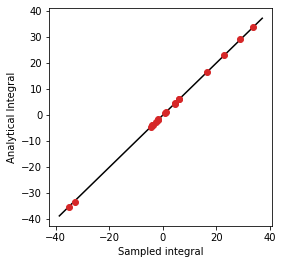

In [5]:
# Sample integral
x_sample = phi_xy.sample(10000)
Ax_a_sample = numpy.einsum('ab,cdb->cda', A_mat, x_sample) + a_vec
Bx_b_sample = numpy.einsum('ab,cdb->cda', B_mat, x_sample) + b_vec
AB_sample = numpy.mean(numpy.einsum('abc,abd->abcd', Ax_a_sample, Bx_b_sample), axis=0)
# Plot
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(AB_sample), 1.1 * numpy.amax(AB_sample)], [1.1 * numpy.amin(AB_sample), 1.1 * numpy.amax(AB_sample)] ,'k')
pyplot.plot(AB_sample.flatten(), AB_phi_xy.flatten(), 'C3o')
pyplot.xlabel('Sampled integral')
pyplot.ylabel('Analytical Integral')
pyplot.show()

## Up to Quartic integral

$\int (Ax+a)(Bx+b)^\top(Cx+c)(Dx+d)^\top d\phi(x)$ 

In [6]:
# Generate matrices & vectors
m,l,k = 4,6,8
A_mat, a_vec = numpy.random.randn(m,D), numpy.random.rand(m)
B_mat, b_vec = numpy.random.randn(l,D), numpy.random.rand(l)
C_mat, c_vec = numpy.random.randn(l,D), numpy.random.rand(l)
D_mat, d_vec = numpy.random.randn(k,D), numpy.random.rand(k)
# Integrate
ABCD_phi_xy = phi_xy.integrate('Ax_aBx_bCx_cDx_d_outer', A_mat=A_mat, a_vec=a_vec, 
                                                   B_mat=B_mat, b_vec=b_vec, 
                                                   C_mat=C_mat, c_vec=c_vec, 
                                                   D_mat=D_mat, d_vec=d_vec)

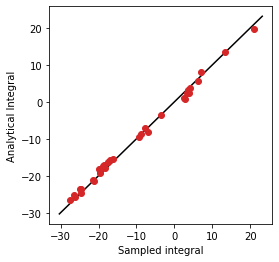

In [7]:
# Sample integral
x_sample = phi_xy.sample(10000)
Ax_a_sample = numpy.einsum('ab,cdb->cda', A_mat, x_sample) + a_vec
Bx_b_sample = numpy.einsum('ab,cdb->cda', B_mat, x_sample) + b_vec
Cx_c_sample = numpy.einsum('ab,cdb->cda', C_mat, x_sample) + c_vec
Dx_d_sample = numpy.einsum('ab,cdb->cda', D_mat, x_sample) + d_vec
AB_sample = numpy.einsum('abc,abd->abcd', Ax_a_sample, Bx_b_sample)
CD_sample = numpy.einsum('abc,abd->abcd', Cx_c_sample, Dx_d_sample)
ABCD_sample = numpy.mean(numpy.einsum('abcd,abde->abce', AB_sample, CD_sample), axis=0)
# Plot
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(ABCD_sample), 1.1 * numpy.amax(ABCD_sample)], [1.1 * numpy.amin(ABCD_sample), 1.1 * numpy.amax(ABCD_sample)] ,'k')
pyplot.plot(ABCD_sample.flatten(), ABCD_phi_xy.flatten(), 'C3o')
pyplot.xlabel('Sampled integral')
pyplot.ylabel('Analytical Integral')
pyplot.show()

# Gaussian manipulation

## `get_marginal()` function

$p(x,y)\rightarrow p(x)$

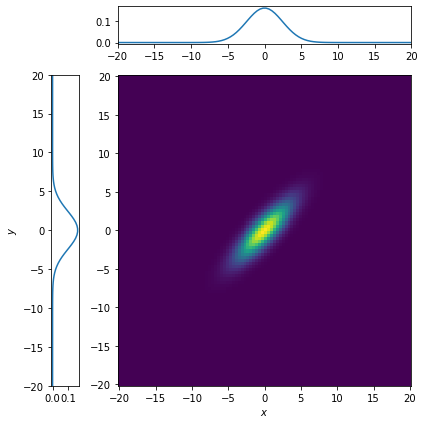

In [8]:
# Get the marginals
phi_x = phi_xy.get_marginal([0])
phi_y = phi_xy.get_marginal([1])
x = numpy.array([xrange]).T

# Plotting
from matplotlib import gridspec
fig = pyplot.figure(figsize=(6,6))
grid = gridspec.GridSpec(6,6,fig)
ax1 = fig.add_subplot(grid[1:,:1])
ax1.plot(phi_y.evaluate(x).T, x)
ax1.set_ylim([x[0,0], x[-1,0]])
ax1.set_ylabel('$y$')
ax2 = fig.add_subplot(grid[:1,1:])
ax2.plot(x,phi_x.evaluate(x).T)
ax2.set_xlim([x[0,0], x[-1,0]])
ax3 = fig.add_subplot(grid[1:,1:])
ax3.pcolor(xrange, xrange, density, shading='auto')
ax3.set_xlabel('$x$')
pyplot.tight_layout()

## `condition_on()` function

$p(x,y)\rightarrow p(x\vert y)$

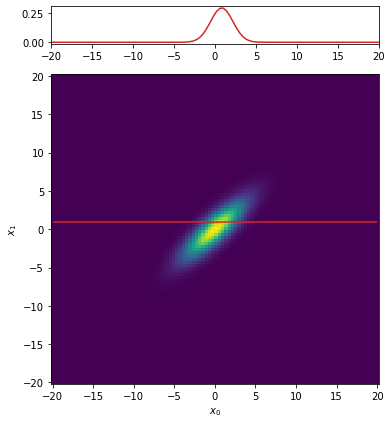

In [9]:
# Conditioning
cond_phi_x_y = phi_xy.condition_on([0])
# Get density conditioned on a specific point
cond_y = numpy.ones((1,1))
dens_cond_phi_x_y0 = cond_phi_x_y.condition_on_x(cond_y)

# Plotting
from matplotlib import gridspec
fig = pyplot.figure(figsize=(6,6))
grid = gridspec.GridSpec(6,6,fig)
ax2 = fig.add_subplot(grid[:1,1:])
ax2.plot(x,dens_cond_phi_x_y0.evaluate(x).T, 'C3')
ax2.set_xlim([x[0,0], x[-1,0]])
ax3 = fig.add_subplot(grid[1:,1:])
ax3.hlines(cond_y, xrange[0], xrange[-1], 'C3')
ax3.pcolor(xrange, xrange, density, shading='auto')
ax3.set_xlabel('$x_0$')
ax3.set_ylabel('$x_1$')
pyplot.tight_layout()

# Affine transformations

$p(x\vert y), p(x) \rightarrow p(x,y)$ with `affine_joint_transformation()`

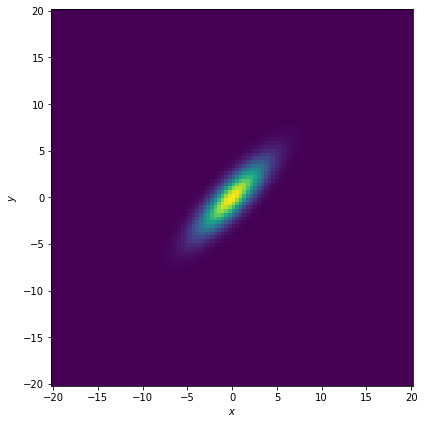

In [10]:
new_phi_xy = phi_y.affine_joint_transformation(cond_phi_x_y)

# Plotting
from matplotlib import gridspec
fig = pyplot.figure(figsize=(6,6))
grid = gridspec.GridSpec(6,6,fig)
ax3 = fig.add_subplot(grid[:,:])
new_density = new_phi_xy.evaluate(x_grid.T)[0].reshape((100,100))
ax3.pcolor(xrange, xrange, new_density, shading='auto')
ax3.set_xlabel('$x$')
ax3.set_ylabel('$y$')
pyplot.tight_layout()

$p(x\vert y), p(x) \rightarrow p(y\vert x)$ with `affine_conditional_transformation()`

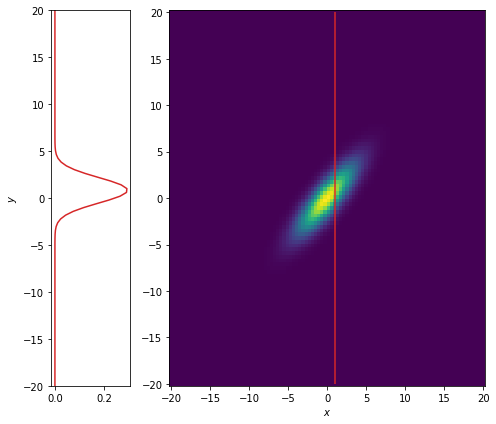

In [11]:
cond_phi_y_x = phi_y.affine_conditional_transformation(cond_phi_x_y)
# Get density conditioned on a specific point
cond_x = numpy.ones((1,1))
dens_cond_phi_y_x0 = cond_phi_y_x.condition_on_x(cond_x)

# Plotting
from matplotlib import gridspec
fig = pyplot.figure(figsize=(7,6))
grid = gridspec.GridSpec(6,8,fig)
ax2 = fig.add_subplot(grid[:,:2])
ax2.plot(dens_cond_phi_y_x0.evaluate(x).T, x, 'C3')
ax2.set_ylim([x[0,0], x[-1,0]])
ax2.set_ylabel('$y$')
ax3 = fig.add_subplot(grid[:,2:])
ax3.vlines(cond_x, xrange[0], xrange[-1], 'C3')
ax3.pcolor(xrange, xrange, density, shading='auto')
ax3.set_xlabel('$x$')
pyplot.tight_layout()

$p(x\vert y), p(x) \rightarrow p(y)$ with `affine_marginal_transformation()`

TBD

# An application: Kalman filter

Here we use the Gaussian Toolbox to implement a Kalman filter which has the form

$$
z_{t} = A z_{t-1} + b + \zeta_t \\
x_{t} = C z_t + d + \xi_t,
$$

where $x_t$ are our observations and $z_t$ latent (unobserved) variables. Furthermore, the noise variables are

$$
\zeta_t \sim N(0,Q_z)\\
\xi_t \sim N(0,Q_x).
$$

In [12]:
class KalmanFilter:
    
    def __init__(self, X: numpy.ndarray, A: numpy.ndarray, b: numpy.ndarray, Qz: numpy.ndarray, 
                 C: numpy.ndarray, d: numpy.ndarray, Qx: numpy.ndarray):
        """ This is a linear Kalman filter.
        
        :param X: numpy.ndarray [N, Dx]
            The observed data.
        :param A: numpy.ndarray [Dz, Dz]
            The state transition matrix.
        :param b: numpy.ndarray [Dz]
            The state transition offset.
        :param Qz: numpy.ndarray [Dz, Dz]
            The state covariance.
        :param C: numpy.ndarray [Dx, Dz]
            The observation matrix.
        :param d: numpy.ndarray [Dx]
            The observation offset.
        :param Qx: numpy.ndarray [Dx, Dx]
            The observation covariances. 
        """
        self.Dz, self.Dx = Qz.shape[0], Qx.shape[0]
        self.T = X.shape[0]
        self.X = X
        self.state_density = conditionals.ConditionalGaussianDensity(numpy.array([A]), numpy.array([b]), numpy.array([Qz]))
        self.emission_density = conditionals.ConditionalGaussianDensity(numpy.array([C]), numpy.array([d]), numpy.array([Qx]))
        self.prediction_density = self._setup_density()
        self.filter_density = self._setup_density()
        
    def _setup_density(self) -> densities.GaussianDensity:
        """ Initializes a density object (with uniform densities).
        """
        Sigma = numpy.tile(numpy.eye(self.Dz)[None], (self.T+1,1,1))
        Lambda = numpy.tile(numpy.eye(self.Dz)[None], (self.T+1,1,1))
        mu = numpy.zeros((self.T + 1, self.Dz))
        ln_det_Sigma = self.Dz * numpy.log(numpy.ones(self.T+1))
        return densities.GaussianDensity(Sigma, mu, Lambda, ln_det_Sigma)
        
        
    def forward_path(self):
        """ Forward iteration.
        """
        for t in range(1, self.T+1):
            self.prediction(t)
            self.filtering(t)
        
        
    def prediction(self, t: int):
        """ Here the prediction density is calculated.
        
        p(z_t|x_{1:t-1}) = int p(z_t|z_t-1)p(z_t-1|x_1:t-1) dz_t-1
        
        :param t: int
            Time index.
        """
        # p(z_t-1|x_{1:t-1})
        pre_filter_density = self.filter_density.slice([t-1])
        # p(z_t|x_{1:t-1})
        cur_prediction_density = pre_filter_density.affine_marginal_transformation(self.state_density)
        # Write result into prediction density collection
        self.prediction_density.update([t], cur_prediction_density)
        
        
    def filtering(self, t: int):
        """ Here the filtering density is calculated.
        
        p(z_t|x_{1:t}) = p(x_t|z_t)p(z_t|x_{1:t-1}) / p(x_t)
        
        :param t: int
            Time index.
        """
        # p(z_t|x_{1:t-1})
        cur_prediction_density = self.prediction_density.slice([t])
        # p(z_t| x_t, x_{1:t-1})
        p_z_given_x = cur_prediction_density.affine_conditional_transformation(self.emission_density)
        # Condition on x_t
        cur_filter_density = p_z_given_x.condition_on_x(self.X[t-1:t])
        # Write result into filter density collection
        self.filter_density.update([t], cur_filter_density)

In [13]:
T = 1000
trange = numpy.arange(T)
Dx = 2
Dz = 2
X = numpy.empty((T,Dx))
X[:,0] = numpy.sin(trange / 20)
X[:,1] = numpy.sin(trange / 10)
noise_x = .2
noise_z = .1
X += noise_x * numpy.random.randn(*X.shape)
Qx = noise_x ** 2 * numpy.eye(Dx)
Qz = noise_z ** 2 * numpy.eye(Dz)
A, b = numpy.eye(Dz), numpy.zeros((Dz,))
C, d = numpy.eye(Dx), numpy.zeros((Dx,))
kf = KalmanFilter(X, A, b, Qz, C, d, Qx)
kf.forward_path()

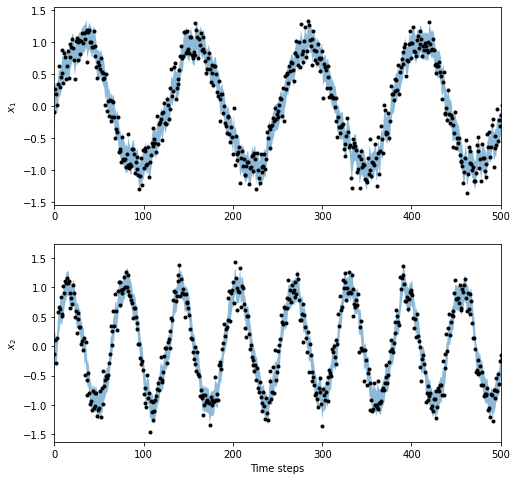

In [14]:
mean_estimate = kf.filter_density.mu
std_estimate = 1.68 * numpy.sqrt(kf.filter_density.Sigma.diagonal(axis1=1, axis2=2))

pyplot.figure(figsize=(8,8))
ax1 = pyplot.subplot(211)
pyplot.plot(X[:,0], 'k.')
pyplot.fill_between(range(T), mean_estimate[1:,0] - std_estimate[1:,0], mean_estimate[1:,0] + std_estimate[1:,0], alpha=.5)
pyplot.xlim([0,500])
pyplot.ylabel('$x_1$')
pyplot.subplot(212, sharex=ax1)
pyplot.plot(X[:,1], 'k.')
pyplot.fill_between(range(T), mean_estimate[1:,1] - std_estimate[1:,1], mean_estimate[1:,1] + std_estimate[1:,1], 
                    alpha=.5)
pyplot.xlabel('Time steps')
pyplot.ylabel('$x_2$')
pyplot.show()

# Integrating with respect to Gaussian terms

Assume we have a vector of Gaussian kernels

$\Psi(x) = (k(x,\hat{x}_1), \ldots, k(x,\hat{x}_N))^\top$ with $k(x,\hat{x})=\beta_k\exp(-\frac{1}{2}(x-\hat{x})^\top\Lambda_k^{-1}(x-\hat{x}))$ and we want to solve

$\int \Psi(x)\Psi(x)^\top d\phi(x)$.

In [15]:
# Generate kernel
num_kernels = 100
center_range = numpy.linspace(-2,2,int(numpy.sqrt(num_kernels)))
center_mesh = numpy.meshgrid(center_range, center_range)
centers_kernel = numpy.vstack([center_mesh[0].flatten(), center_mesh[1].flatten()]).T
kernel_width = 1.
Lambda_kernel = 1. / kernel_width * numpy.eye(D)
Lambda_kernel = numpy.tile(Lambda_kernel, (num_kernels, 1, 1))
nu_kernel = centers_kernel / kernel_width
ln_beta_kernel = -numpy.sum(kernel_width * nu_kernel ** 2, axis=1)
# Conjugate factor
kernel = factors.ConjugateFactor(Lambda=Lambda_kernel, nu=nu_kernel, ln_beta=ln_beta_kernel)

## `multiply()` function and `GaussianMeasure`

In [16]:
kk_phi = phi_xy.multiply(kernel).multiply(kernel)
integral = kk_phi.integrate()

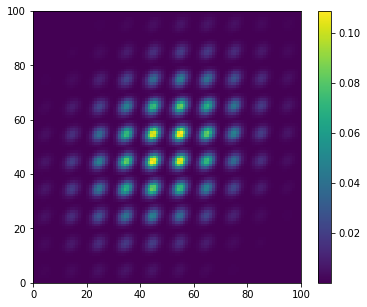

In [17]:
pyplot.figure(figsize=(6,5))
pyplot.pcolor(integral.reshape((num_kernels, num_kernels)))
pyplot.colorbar()